# Tests for derivative-free optimization methods 

In [1]:
import numpy as np 
from scipy.optimize import minimize
import random as rd
from random import seed
seed(0) # for reproducibility

## Some test objective functions 

These functions are taken from https://en.wikipedia.org/wiki/Test_functions_for_optimization

In [2]:
#### DEFINE TESTS FUNCTIONS ####
def sphere(x):
    return sum([xᵢ**2 for xᵢ in x])

def rastrigin(x):
    return 10*len(x) + sum([xᵢ**2 - 10*np.cos( 2*np.pi*xᵢ ) for xᵢ in x])

def ackley(x):
    return -20*np.exp( -0.2*np.sqrt( 0.5*(x[0]**2 + x[1]**2) ) ) \
            - np.exp( 0.5*(np.cos( 2*np.pi*x[0] ) + np.cos( 2*np.pi*x[1] )) ) + np.exp(1) + 20

def rosenbrock(x):
    n = len(x)
    res = 0.0
    for i in range(n-1):
        res += 100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    
    return res
## all minima here are [0,...,0]

# test 
x = [0,2]
sphere(x), rastrigin(x), ackley(x), rosenbrock(x)

(4, 4.0, 4.927233671124704, 401.0)

## helper functions 

This notebook is mainly supported in the `scipy.optimize.minimize` function which has both derivative-dependant and derivative-free in-built methods. 

In [3]:
### Run a bunch of simulations using certain test function and a certain method 
def optimization_ensemble(f, method, dimx0, n_sims=10, x_lims=(-5,5), tol=1e-3):
    ξ = rd.random # uniform distribution function
    x_min, x_max = x_lims

    # method = "Nelder-Mead"
    # f = rosenbrock

    # preallocation
    success_rate = 0
    f_vals = []
    n_iters_array = []
    n_fevals_array = []

    for sim in range(n_sims):
        # for reproducibility of initial conditions between methods
        rd.seed(sim) 
        # initialize initial search point at random in [x_min, x_max]
        x0 = [ x_min + (x_max - x_min)*ξ() for i in range(dimx0) ]
        # minimize the objective `f` with a given optimization `method`
        minimizer = minimize(f, x0, method=method, options={'disp':False}, tol=tol)
        ## obs: tol in minimize is wrt Δf. tol in minimizer['fun'] is with respect to f itself.
        
        # this step is artesanal as the built-in function doesn't behave as I want.
        # I know that min_x(f) = 0 for all my test objectives, so...
        # If the minimizer converged to the global minimum
        # if I want to measure local minima, do minimizer['status'] \in {0: success, 1: failure}
        if minimizer['fun'] <= tol:
            success_rate += 1
            f_vals.append(minimizer['fun'])
            n_iters_array.append(minimizer['nit'])
            n_fevals_array.append(minimizer['nfev'])
    
    return { 
             'f_avg': np.mean(f_vals), 'f_std': np.std(f_vals), 'n_iters_avg':np.mean(n_iters_array), 'n_iters_std':np.std(n_iters_array),
             'n_fevals_avg':np.mean(n_fevals_array), 'n_fevals_std':np.std(n_fevals_array),
             'success_rate': success_rate/n_sims,
           }

In [4]:
# Sweep the dimensionality of the problem by changing the number of components of x in f(x)
def sweep_dimx0(dofs, f, method, n_sims=10, x_lims=(-5,5)):

    ## preallocation
    f_array = np.zeros( len(dofs) )
    f_array_std = np.zeros( len(dofs) )
    n_iters_array = np.zeros( len(dofs) )
    n_iters_array_std = np.zeros( len(dofs) )
    n_fevals_array = np.zeros( len(dofs) )
    n_fevals_array_std = np.zeros( len(dofs) )
    success_rate_array = np.zeros( len(dofs) )
    
    # dofs is a list of the degrees of freedom of x0, i.e. its dimension.
    for (i,n) in enumerate(dofs):
        print('Running ensemble for dim(x) = {}...'.format(n))
        # run the optimization of `f` for `n_sims` simulations using `method` 
        ensemble = optimization_ensemble(f, method, n, n_sims=n_sims, x_lims=x_lims)
        
        f_array[i] = ensemble['f_avg']
        f_array_std[i] = ensemble['f_std']
        n_iters_array[i] = ensemble['n_iters_avg']
        n_iters_array_std[i] = ensemble['n_iters_std']
        n_fevals_array[i] = ensemble['n_fevals_avg']
        n_fevals_array_std[i] = ensemble['n_fevals_std']
        success_rate_array[i] = ensemble['success_rate']
        
    return {
        'method': method,
        'objective': f.__name__,
        'n_sims': n_sims,
        'dofs': dofs,
        'fun': f_array, 'fun_std': f_array_std,
        'n_iters': n_iters_array, 'n_iters_std': n_iters_array_std,
        'n_fevals': n_fevals_array, 'n_fevals_std': n_fevals_array_std,
        'success_rate': success_rate_array,
    }

In [5]:
## Run the optimization through a bunch of methods at a range of dimensions of x. 
def main(n_sims=100):
    f = rosenbrock
    methods = ["Nelder-Mead", "Powell", "CG", "BFGS"]
    dofs = range(2,16)
    x_min, x_max = (-10, 10)
    
    # preallocation (array of dictionaries that contain all)
    results = []
    for method in methods:
        print( 'Simulating {} objective with {} method...'.format( f.__name__, method ) )
        results.append( sweep_dimx0(dofs, f, method, n_sims=n_sims, x_lims=(x_min, x_max)) )
    
    print('Done!')
    return results

In [6]:
# 7 min 54 sec.
# call main function... time consuming when n_sims >> 1
%time results = main()

Simulating rosenbrock objective with Nelder-Mead method...
Running ensemble for dim(x) = 2...
Running ensemble for dim(x) = 3...
Running ensemble for dim(x) = 4...
Running ensemble for dim(x) = 5...
Running ensemble for dim(x) = 6...
Running ensemble for dim(x) = 7...
Running ensemble for dim(x) = 8...


/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running ensemble for dim(x) = 9...
Running ensemble for dim(x) = 10...
Running ensemble for dim(x) = 11...
Running ensemble for dim(x) = 12...
Running ensemble for dim(x) = 13...
Running ensemble for dim(x) = 14...
Running ensemble for dim(x) = 15...
Simulating rosenbrock objective with Powell method...
Running ensemble for dim(x) = 2...
Running ensemble for dim(x) = 3...
Running ensemble for dim(x) = 4...
Running ensemble for dim(x) = 5...
Running ensemble for dim(x) = 6...
Running ensemble for dim(x) = 7...
Running ensemble for dim(x) = 8...
Running ensemble for dim(x) = 9...
Running ensemble for dim(x) = 10...
Running ensemble for dim(x) = 11...
Running ensemble for dim(x) = 12...
Running ensemble for dim(x) = 13...
Running ensemble for dim(x) = 14...
Running ensemble for dim(x) = 15...
Simulating rosenbrock objective with CG method...
Running ensemble for dim(x) = 2...
Running ensemble for dim(x) = 3...
Running ensemble for dim(x) = 4...
Running ensemble for dim(x) = 5...
Running e

# Plotting 

In [7]:
## Plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
font = {'family' : 'DejaVu Sans',
#         'weight' : 'bold',
        'size'   : 16}

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend', fontsize=14)
matplotlib.rc('font', **font)

### This makes plotting much prettier
plt.style.use('seaborn-poster') #bhm

print(plt.style.available)

['Solarize_Light2', '_classic_test', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


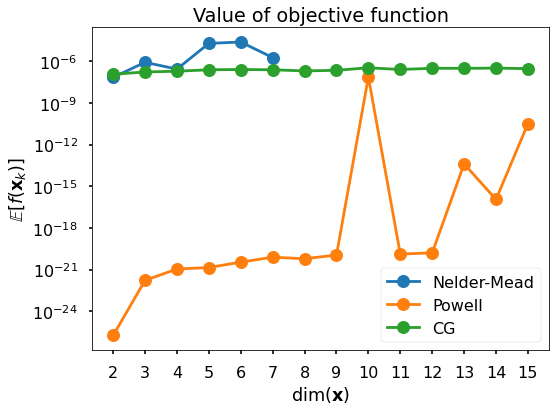

In [8]:
# with results[:-1], I ignore the results for the BFGS method, which is a quasi-Newton optimization method
plt.figure( figsize=(8,6) )

for res in results[:-1]:
    plt.errorbar(res['dofs'], res['fun'], label=res['method'], 
                 fmt='-o', capsize=8, ms=13)

dofs = range(2,16)
plt.xticks(dofs)

plt.legend(loc='lower right')
plt.title('Value of objective function')
plt.xlabel('$\dim( \mathbf{x} )$')
# plt.ylabel('$< f( \mathbf{x}_k ) >$')
plt.ylabel('$\mathbb{E}[ f( \mathbf{x}_k ) ]$')
plt.yscale('log')
plt.tight_layout()

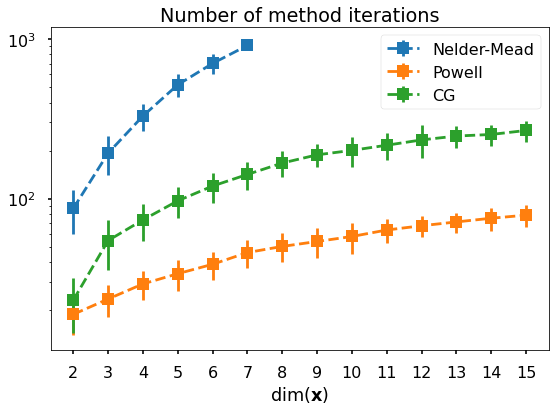

In [9]:
plt.figure( figsize=(8,6) )
for res in results[:-1]:
    plt.errorbar(res['dofs'], res['n_iters'], yerr=res['n_iters_std'], label=res['method'], 
                 fmt='--s', capsize=8, ms=12)
    
plt.xticks(dofs)
    
plt.legend()
plt.title('Number of method iterations')
plt.xlabel('$\dim( \mathbf{x} )$')
plt.yscale('log')
plt.tight_layout()

Text(0.5, 0, '$\\dim( \\mathbf{x} )$')

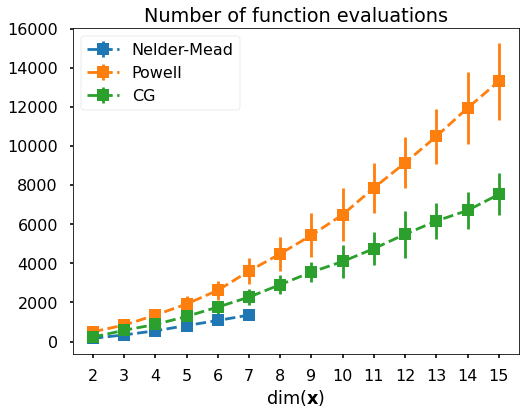

In [10]:
plt.figure( figsize=(8,6) )
for res in results[:-1]:
    plt.errorbar(res['dofs'], res['n_fevals'], yerr=res['n_fevals_std'], label=res['method'], 
                 fmt='--s', capsize=8, ms=12)
    
plt.xticks(dofs)
    
plt.legend(loc='upper left')
plt.title('Number of function evaluations')
plt.xlabel('$\dim( \mathbf{x} )$')
# plt.yscale('log')

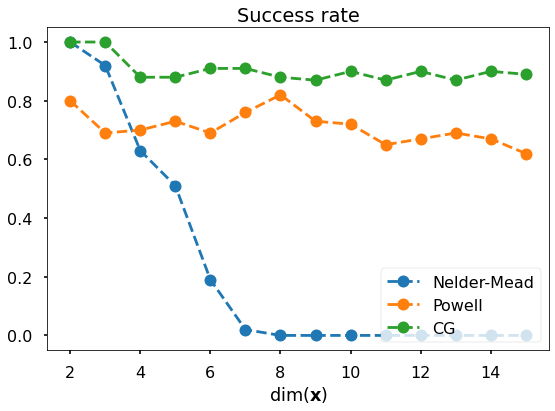

In [11]:
plt.figure( figsize=(8,6) )
for res in results[:-1]:
    plt.errorbar(res['dofs'], res['success_rate'], label=res['method'], 
                 fmt='--o', capsize=8, ms=12)
    
plt.legend(loc='lower right')
plt.title('Success rate')
plt.xlabel('$\dim( \mathbf{x} )$')
plt.tight_layout()
# plt.yscale('log')